In [1]:
pip install torch torchvision pandas matplotlib scikit-learn pillow


  Using cached torch-2.6.0-cp312-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached torchvision-0.21.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached MarkupSafe-3.0.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (4.0 kB)
Using cached torch-2.6.0-cp312-none-macosx_11_0_arm64.whl (66.5 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached torchvision-0.21.0-cp312-cp312-macosx_11_0_arm64.whl (1.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 18.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 21.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 24.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 24.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.6 MB/s eta 

In [16]:
!pip install seaborn

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from PIL import Image as PILImage
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
#Data Preparation
utkface_dir = "/Users/hammazbuksh/Downloads/archive (10)/UTKFace"  # <-- change this to your folder path

# Load filenames and extract ethnicity labels
from collections import defaultdict

per_class_limit = 1000  # Limit to max 1000 images per class
class_counter = defaultdict(int)
data = []


#loop through all files in the directory
for fname in os.listdir(utkface_dir):
    if fname.endswith(".jpg"):
        parts = fname.split("_")
        try:
            age, gender, ethnicity = parts[:3]
            ethnicity = int(ethnicity)
            if class_counter[ethnicity] < per_class_limit:
                data.append({"file": os.path.join(utkface_dir, fname), "ethnicity": ethnicity})
                class_counter[ethnicity] += 1
        except:
            continue

df = pd.DataFrame(data)


#Safety check: stops the script if the dataset was empty or paths were wrong
if df.empty:
    raise ValueError("No valid data found. Check file naming or path.")


#Split Data into Train and Test Sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['ethnicity'], random_state=42)

#Define Transformations for Images
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])

#Define a Custom PyTorch Dataset Class
class UTKFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = PILImage.open(row['file']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, int(row['ethnicity'])

In [13]:
#Wrap the DataFrames into PyTorch Datasets
train_dataset = UTKFaceDataset(train_df, transform=transform)
test_dataset = UTKFaceDataset(test_df, transform=transform)

#Calculate Class Weights to Handle Imbalance
class_counts = train_df['ethnicity'].value_counts().sort_index()
class_weights = 1. / torch.tensor(class_counts.values, dtype=torch.float)

#Assign Weights to Each Sample
sample_weights = [class_weights[label] for label in train_df['ethnicity']]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

#Create Data Loaders for Training and Testing
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

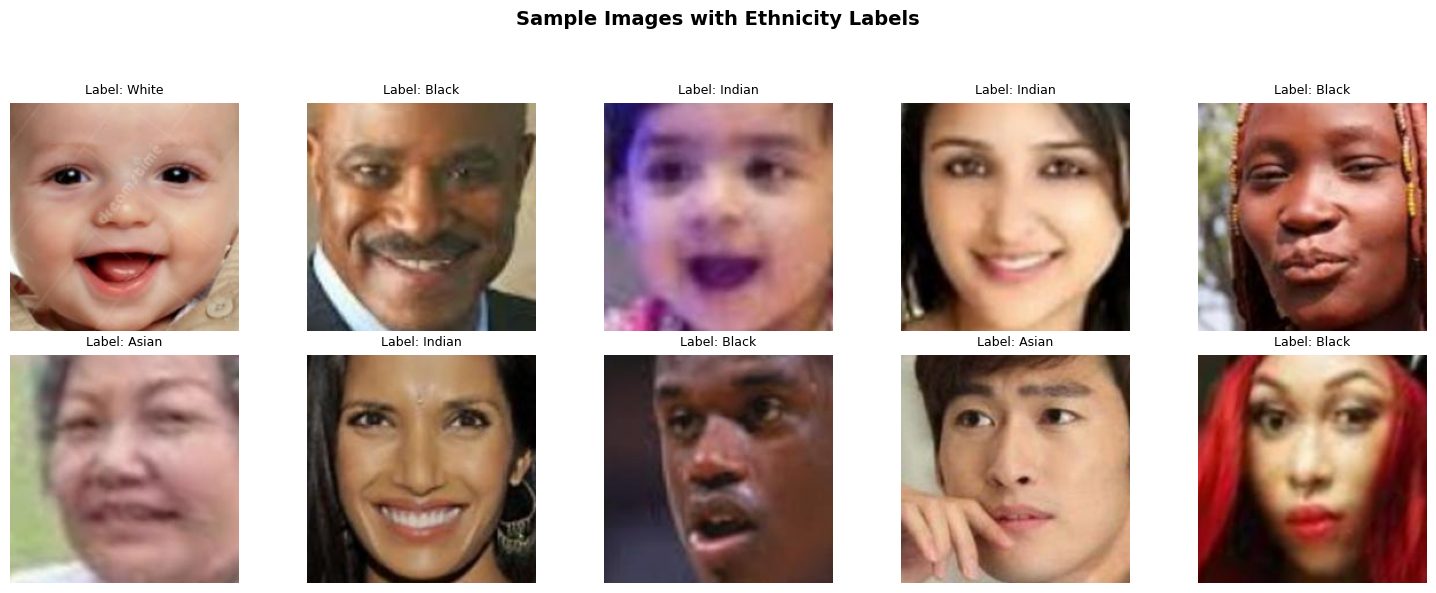

In [14]:

preview_dataset = UTKFaceDataset(df.sample(10, random_state=42), transform=transform)
preview_loader = DataLoader(preview_dataset, batch_size=10, shuffle=False)
ethnicity_labels = ["White", "Black", "Asian", "Indian", "Other"]
images, labels = next(iter(preview_loader))
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    img = images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(f"Label: {ethnicity_labels[labels[i]]}", fontsize=9)
    ax.axis("off")
plt.suptitle("Sample Images with Ethnicity Labels", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [10]:
# 2. Model Definition
# ===============================
class EthnicityCNN(nn.Module):
    def __init__(self):
        super(EthnicityCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 25 * 25, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 5)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


In [11]:
# 3. Training Setup
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EthnicityCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [15]:
# 4. Training Loop
# ===============================
epochs = 30
train_loss_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


Epoch 1/30, Loss: 1.5217
Epoch 2/30, Loss: 1.3887
Epoch 3/30, Loss: 1.2353
Epoch 4/30, Loss: 1.1089
Epoch 5/30, Loss: 1.0087
Epoch 6/30, Loss: 0.9643
Epoch 7/30, Loss: 0.9169
Epoch 8/30, Loss: 0.8537
Epoch 9/30, Loss: 0.7998
Epoch 10/30, Loss: 0.7600
Epoch 11/30, Loss: 0.7070
Epoch 12/30, Loss: 0.6669
Epoch 13/30, Loss: 0.6228
Epoch 14/30, Loss: 0.5971
Epoch 15/30, Loss: 0.5733
Epoch 16/30, Loss: 0.5362
Epoch 17/30, Loss: 0.5039
Epoch 18/30, Loss: 0.4612
Epoch 19/30, Loss: 0.4381
Epoch 20/30, Loss: 0.3909
Epoch 21/30, Loss: 0.3512
Epoch 22/30, Loss: 0.3412
Epoch 23/30, Loss: 0.3212
Epoch 24/30, Loss: 0.2927
Epoch 25/30, Loss: 0.2949
Epoch 26/30, Loss: 0.2899
Epoch 27/30, Loss: 0.2662
Epoch 28/30, Loss: 0.2516
Epoch 29/30, Loss: 0.2294
Epoch 30/30, Loss: 0.2273


In [16]:
# 5. Evaluation
# ===============================
model.eval()
y_true, y_pred = [], []
example_images = []
example_labels = []
example_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

        if len(example_images) < 5:
            example_images.extend(images.cpu())
            example_labels.extend(labels.numpy())
            example_preds.extend(preds.cpu().numpy())

print("\nAccuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))



Accuracy: 0.668

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.65      0.66       200
           1       0.79      0.72      0.76       200
           2       0.74      0.78      0.76       200
           3       0.66      0.66      0.66       200
           4       0.50      0.53      0.52       200

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000


Confusion Matrix:
 [[130   7  20  14  29]
 [ 10 145   6  18  21]
 [ 15   5 155   5  20]
 [ 13  11   9 132  35]
 [ 28  15  19  32 106]]


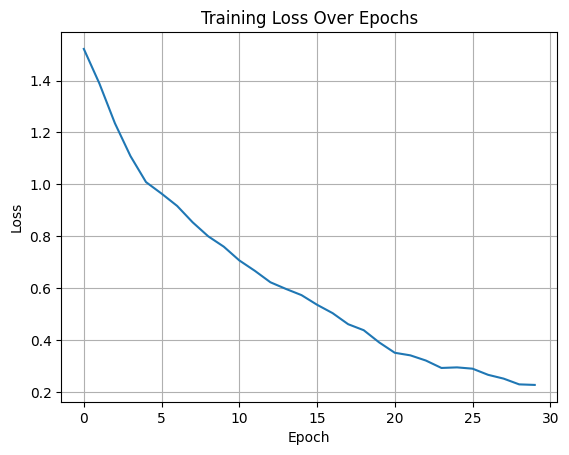

In [17]:

# ===============================
plt.plot(train_loss_history)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

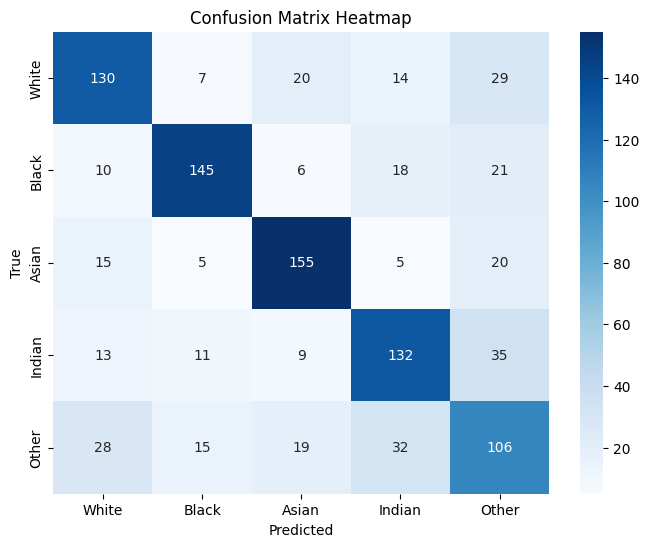

In [18]:
ethnicity_labels = ["White", "Black", "Asian", "Indian", "Other"]
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=ethnicity_labels, yticklabels=ethnicity_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()

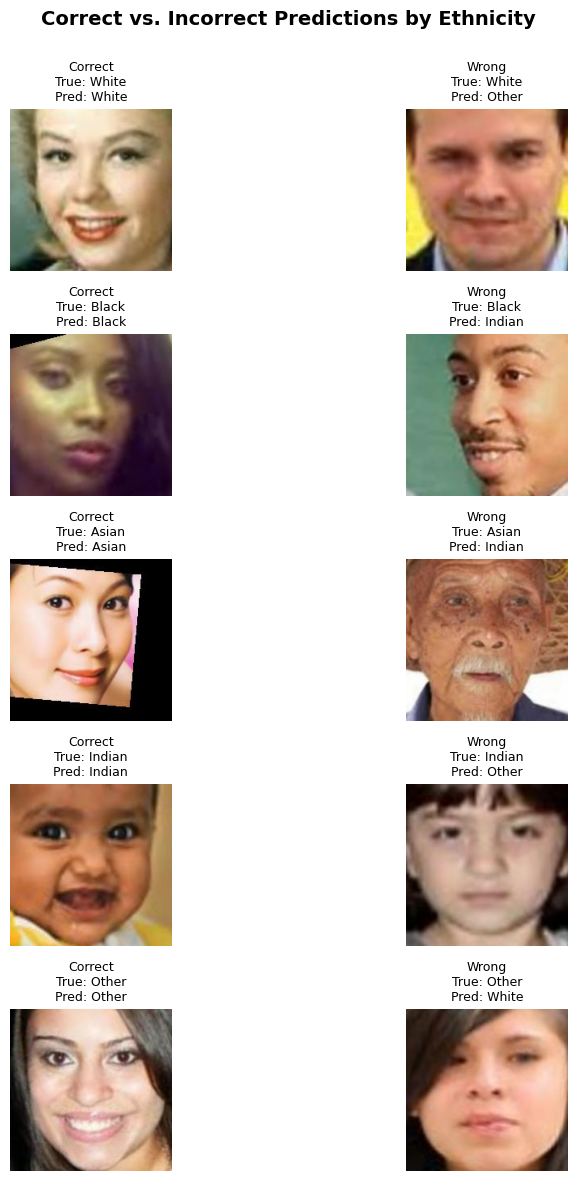

In [19]:
#Display Example Predictions
# ===============================
fig, axes = plt.subplots(5, 2, figsize=(10, 12))
shown_classes = set()

# Expand example_images to include more candidates from test set
extra_examples = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for i in range(images.size(0)):
            example_images.append(images[i].cpu())
            example_labels.append(labels[i].item())
            example_preds.append(preds[i].item())
            extra_examples += 1
        if extra_examples >= 200:
            break

for true_class in range(5):
    correct_found = False
    incorrect_found = False
    for i, (img, true_label, pred_label) in enumerate(zip(example_images, example_labels, example_preds)):
        if true_label == true_class:
            if true_label == pred_label and not correct_found:
                ax = axes[true_class, 0]
                ax.imshow(np.clip(img.permute(1, 2, 0).numpy(), 0, 1))
                ax.set_title(f"Correct\nTrue: {ethnicity_labels[true_label]}\nPred: {ethnicity_labels[pred_label]}", fontsize=9)
                correct_found = True
            elif true_label != pred_label and not incorrect_found:
                ax = axes[true_class, 1]
                ax.imshow(np.clip(img.permute(1, 2, 0).numpy(), 0, 1))
                ax.set_title(f"Wrong\nTrue: {ethnicity_labels[true_label]}\nPred: {ethnicity_labels[pred_label]}", fontsize=9)
                incorrect_found = True
        if correct_found and incorrect_found:
            break

for ax_row in axes:
    for ax in ax_row:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Correct vs. Incorrect Predictions by Ethnicity", fontsize=14, fontweight='bold')
plt.show()
